# Importation

In [1]:
import pandas as pd
import random
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
df = pd.read_csv('../data/corpus.csv')

# Séparation test et entrainement

In [3]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

train_df.to_csv('../data/train.csv', index=False)
test_df.to_csv('../data/test.csv', index=False)


### Ouvrir les csv qui ont déjà été divisés

In [4]:
train_df = pd.read_csv('../data/train.csv')
test_df = pd.read_csv('../data/test.csv')

# Baseline 

### Prédiction aléatoire

In [5]:
def random_prediction():
    return random.choice(['Plat principal', 'Entrée', 'Dessert'])

test_df['random prediction'] = test_df.apply(lambda x: random_prediction(), axis=1)


### Prédiction classe majoritaire

In [6]:
def main_class_prediction(train_df):
    main_type = train_df['type'].mode()    
    return main_type

main_type = main_class_prediction(train_df)
test_df['main class prediction'] = test_df.apply(lambda x: main_type, axis=1)

# Model

### SKlearn + Tfi-Df

In [7]:
x_train = train_df['recette']
y_train = train_df['type']

model = make_pipeline(TfidfVectorizer(), MultinomialNB())

model.fit(x_train, y_train)

y_pred = model.predict(test_df['recette'])

test_df['SKlearn prediction'] = y_pred


# Résultat

### Matrice de confusion

Matrice de Confusion : 
                 Dessert  Entrée  Plat principal
Dessert             726       0               0
Entrée                0     611               0
Plat principal        0       0            1158


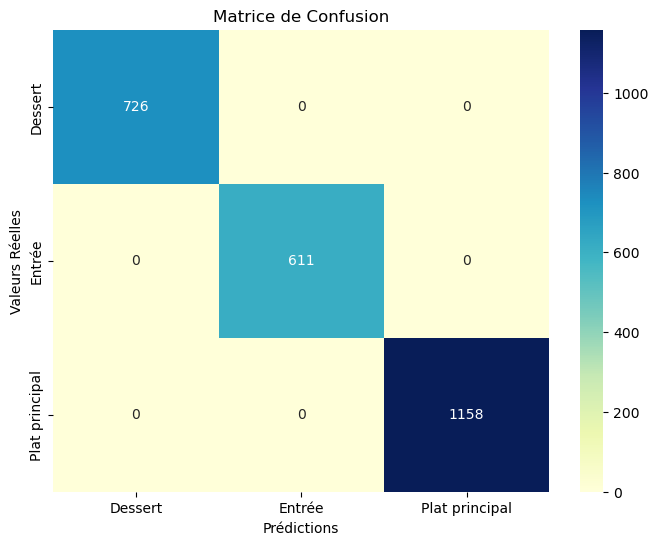

In [10]:
y_test = test_df['type']
y_rand = test_df['random prediction']
y_main = test_df['main class prediction']

conf_matrix = confusion_matrix(y_test, y_test)

conf_df = pd.DataFrame(conf_matrix, index=model.classes_, columns=model.classes_)

print("Matrice de Confusion : \n", conf_df)

plt.figure(figsize=(8,6))
sns.heatmap(conf_df, annot=True, cmap="YlGnBu", fmt='g')
plt.title('Matrice de Confusion')
plt.xlabel('Prédictions')
plt.ylabel('Valeurs Réelles')
plt.show()

### Rappel - Précision - F-mesure

In [9]:
report = classification_report(y_test, y_pred)
print(report)


                precision    recall  f1-score   support

       Dessert       0.96      0.96      0.96       726
        Entrée       0.85      0.06      0.11       611
Plat principal       0.66      0.99      0.79      1158

      accuracy                           0.75      2495
     macro avg       0.83      0.67      0.62      2495
  weighted avg       0.80      0.75      0.67      2495

